**Chapter 10-1 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [2]:
# Python ≥3.7 is required
import sys
print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

from packaging import version
import sklearn
print(sklearn.__version__)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.8.0 is required
import tensorflow as tf

print("TF version: ", tf.__version__)
assert version.parse(tf.__version__) >= version.parse("2.8.0")

# GPU check
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# GPU check
if not "google.colab" in sys.modules: 
    from tensorflow.python.client import device_lib
    print("============")
    print('Device Test')
    print("============")
    print(device_lib.list_local_devices()[0])
    print(device_lib.list_local_devices()[1])

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Where to save the figures
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Python:  sys.version_info(major=3, minor=9, micro=21, releaselevel='final', serial=0)
1.2.2
TF version:  2.10.0
Default GPU Device: /device:GPU:0
Device Test
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14197146829680302491
xla_global_id: -1

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14211350528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15356310306296226207
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419



# From Biological to Artificial Neurons
## Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # predicts True and False for these 2 flowers

In [4]:
y_pred

array([ True, False])

The `Perceptron` is equivalent to a `SGDClassifier` with `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:

In [5]:
# extra code – shows how to build and train a Perceptron

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

When the Perceptron finds a decision boundary that properly separates the classes, it stops learning. This means that the decision boundary is often quite close to one class:

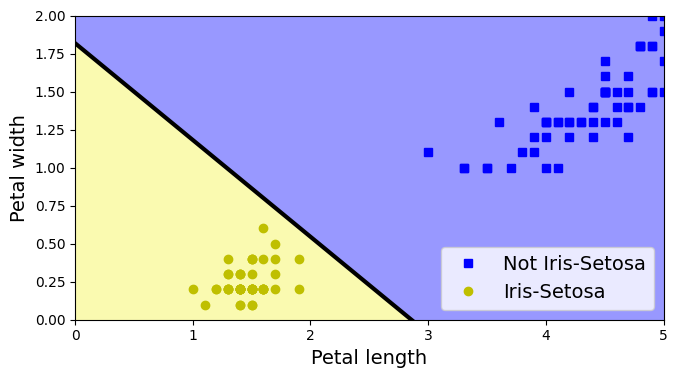

In [6]:
# extra code – plots the decision boundary of a Perceptron on the iris dataset
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(7, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

## Activation functions

In [7]:
from scipy.special import expit as sigmoid
#def sigmoid(z):
#    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

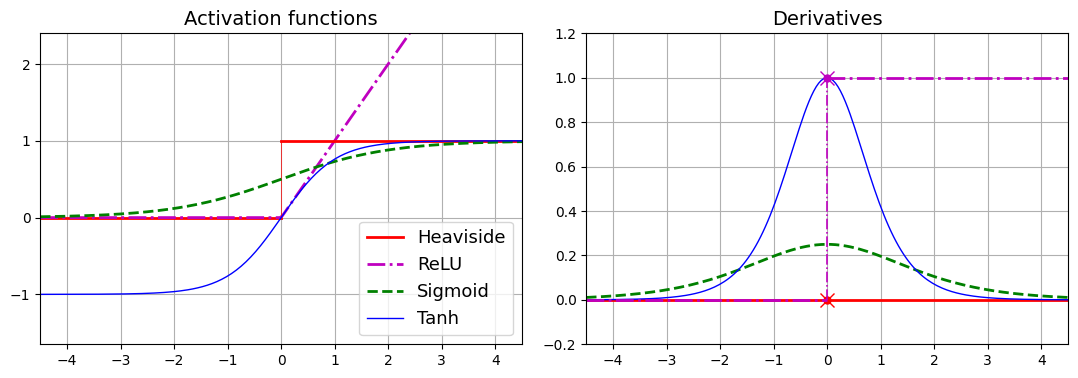

In [8]:
max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Activation functions")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivatives")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

### ==P1. activation functions== 
#### 위의 cell들을 실행후 동작을 설명 
#### Answer: 이 코드는 신경망에서 사용되는 4가지 주요 활성화 함수(Heaviside, ReLU, Sigmoid, Tanh)와 그들의 미분값을 시각화한다.

왼쪽 그래프는 각 활성화 함수의 입력값에 따른 출력값을 보여준다:
- Heaviside: 계단 함수로, x가 0보다 작으면 0, 크면 1을 출력
- ReLU: x가 0보다 작으면 0, 크면 x값 그대로 출력
- Sigmoid: 모든 입력값을 0~1 사이로 압축하는 S자 형태의 함수
- Tanh: 모든 입력값을 -1~1 사이로 압축하는 S자 형태의 함수

오른쪽 그래프는 각 함수의 미분값을 보여준다:
- Heaviside: 0에서 정의되지 않고, 나머지 부분에서는 0
- ReLU: x < 0일 때 0, x > 0일 때 1, x = 0에서 정의되지 않음
- Sigmoid: 값이 0에 가까울 때 최대이고, 입력의 절댓값이 커질수록 0에 가까워짐
- Tanh: 값이 0에 가까울 때 최대이고, 입력의 절댓값이 커질수록 0에 가까워짐

이러한 특성들로 인해 각 활성화 함수는 신경망에서 서로 다른 장단점을 가진다. 특히 Sigmoid와 Tanh는 입력값이 커질수록 미분값이 0에 가까워져 기울기 소실(Vanishing Gradient) 문제를 일으킬 수 있다다.
4개의 activation function 및 미분에 대한 정의와 각 함수의 그림

## Regression MLPs

In [9]:
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)
    
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)

In [10]:
rmse

0.5053326657968666

### ==P2. Regression MLPs= 
#### 위의 cell들을 실행후 동작을 설명 
#### Answer: 이 코드는 캘리포니아 주택 가격 데이터셋을 이용한 회귀 분석을 수행한다.

데이터 준비:

캘리포니아 주택 데이터를 훈련, 검증, 테스트 세트로 분할한다.
특성을 StandardScaler로 정규화한다.


모델 구성:

50개 뉴런을 가진 3개의 은닉층으로 구성된 MLPRegressor를 생성한다.
정규화 과정과 모델을 파이프라인으로 연결한다.


학습 및 평가:

파이프라인을 훈련 데이터로 학습시킨다.
검증 데이터로 예측을 수행하고 RMSE를 계산한다.
결과적으로 약 0.505의 RMSE 값을 얻는다.



이 값은 모델의 예측 오차를 나타내며, 낮을수록 예측 정확도가 높은 것이다.
California Housing 데이터셋을 train, validation, test set으로 분리한 후 MLPRegressor 모델과 standard scaler를 이용하여 학습시킨후 validation dataset에 대해 rmse를 값을 계산한 결과 0.505를 얻음.

## Classification MLPs

In [11]:
# extra code – this was left as an exercise for the reader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

### ==P3. Classification MLPs==
#### 위의 cell들을 실행후 동작을 설명 
#### Answer: 이 코드는 Iris 데이터셋을 이용한 분류 문제를 MLP로 해결한다.

데이터 준비:

Iris 데이터셋을 로드한다.
전체 데이터를 90% 훈련, 10% 테스트로 분할한다.
훈련 데이터를 다시 90% 훈련, 10% 검증 세트로 분할한다.


모델 구성:

5개 뉴런을 가진 1개의 은닉층을 갖는 MLPClassifier를 생성한다.
max_iter=10,000으로 설정하여 충분한 학습 반복을 보장한다.
StandardScaler와 MLPClassifier를 파이프라인으로 연결한다.


학습 및 평가:

파이프라인을 훈련 데이터로 학습시킨다.
검증 데이터에 대한 정확도(accuracy)를 측정한다.
결과적으로 100%의 정확도를 달성한다.



이 결과는 모델이 검증 세트의 모든 샘플을 정확히 분류했음을 의미한다. Iris 데이터셋이 비교적 간단한 문제이기 때문에 단일 은닉층 모델로도 완벽한 분류가 가능했다.
  
  

First let's import TensorFlow and Keras.

In [12]:
#import keras
from tensorflow import keras
keras.__version__

'2.10.0'

### Exercise 10.1
Define and plot activation functions ELU, leaky ReLU and ReLU6 using keras.activation functions.


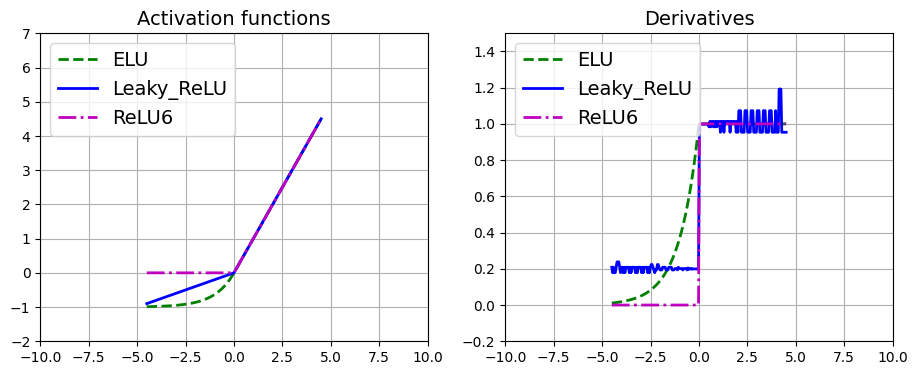

In [13]:
#Exercise 10.1
# Define activation functions using keras.activations
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.layers import LeakyReLU

# Keras에는 직접적인 ReLU6 함수가 없어서 max_value 파라미터를 6으로 설정해서 정의함함
def relu6(x):
    return relu(x, max_value=6)

# Leaky ReLU도 함수로 만들기 (LeakyReLU는 레이어 형태로 제공되므로 함수형 인터페이스로 래핑)
def leaky_relu(x):
    return LeakyReLU(alpha=0.2)(x)

# Plot
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, elu(z), "g--", linewidth=2, label="ELU")
plt.plot(z, leaky_relu(z), "b-", linewidth=2, label="Leaky_ReLU")
plt.plot(z, relu6(z), "m-.", linewidth=2, label="ReLU6")
plt.grid(True)
plt.legend(loc="upper left", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-10, 10, -2, 7])

plt.subplot(122)
plt.plot(z, derivative(elu, z), "g--", linewidth=2, label="ELU")
plt.plot(z, derivative(leaky_relu, z), "b-", linewidth=2, label="Leaky_ReLU")
plt.plot(z, derivative(relu6, z), "m-.", linewidth=2, label="ReLU6")
plt.grid(True)
plt.legend(loc="upper left", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-10, 10, -0.2, 1.5])

plt.show()

### ELU, Leaky ReLU, ReLU6 활성화 함수 설명
위 코드는 세 가지 주요 활성화 함수(ELU, Leaky ReLU, ReLU6)를 TensorFlow Keras를 사용하여 구현하고 시각화한다.
1. 각 활성화 함수 특징
ELU (Exponential Linear Unit):

양수 입력에서는 입력값 그대로 출력
음수 입력에서는 α(e^x - 1) 값을 출력 (부드러운 곡선 형태)
장점: 음수 영역에서도 평균이 0에 가까워져 학습 속도가 향상되고, 기울기 소실 문제를 완화

Leaky ReLU:

양수 입력에서는 입력값 그대로 출력
음수 입력에서는 입력값에 작은 계수(여기서는 0.2)를 곱함
장점: ReLU의 "죽은 뉴런" 문제를 해결(음수 영역에서도 약간의 기울기 유지)

ReLU6:

ReLU의 변형으로, 출력값이 6으로 제한됨
양수 입력에서는 입력값을 출력하되 최대 6까지만 출력
음수 입력에서는 0 출력
장점: 양수 영역에서 수치를 제한하여 계산 효율성 향상, 양자화된 네트워크에 유리

2. 미분값 특징

ELU: 음수 영역에서 완만한 곡선 형태로 미분값이 변화, 양수 영역에서는 항상 1
Leaky ReLU: 음수 영역에서 일정한 작은 값(0.2), 양수 영역에서는 1
ReLU6: 0~6 사이에서는 1, 그 외 영역에서는 0

# Implementing MLPs with Keras
## Building an Image Classifier Using the Sequential API
### Using Keras to load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `tf.keras.datasets`. The dataset is already split for you between a training set (60,000 images) and a test set (10,000 images), but it can be useful to split the training set further to have a validation set. We'll use 55,000 images for training, and 5,000 for validation.

In [14]:
# Fashion MNIST 데이터셋을 Keras에서 로드합니다
fashion_mnist = keras.datasets.fashion_mnist.load_data()
# 데이터셋을 훈련(X_train_full, y_train_full)과 테스트(X_test, y_test)로 분리합니다
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
# 훈련 데이터셋을 다시 훈련(55,000개)과 검증(5,000개)으로 분리합니다
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]  # 뒤에서 5000개를 제외한 나머지
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]  # 뒤에서 5000개

The training set contains 60,000 grayscale images, each 28x28 pixels: 60000개 훈련용 grayscale 이미지(28*28)

In [15]:
# 훈련 데이터셋의 크기와 형태를 확인합니다
print(X_train_full.shape)  # (60000, 28, 28) - 60,000개의 28x28 픽셀 이미지
print(y_train_full.shape)  # (60000,) - 60,000개의 레이블

(60000, 28, 28)
(60000,)


Each pixel intensity is represented as a byte (0 to 255):

In [16]:
# 데이터 타입을 확인합니다 (픽셀 값의 범위는 0-255)
X_train_full.dtype  # uint8 (부호 없는 8비트 정수)

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [17]:
# 픽셀 값을 0-1 범위로 정규화합니다
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.
# 이는 딥러닝 모델 학습에 적합한 형태로 변환하기 위함입니다

In [18]:
# 픽셀 값을 0-1 범위로 정규화합니다
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.
# 이는 딥러닝 모델 학습에 적합한 형태로 변환하기 위함입니다

### ==P4. Using Keras to load the dataset (1)==
#### 1. dataset의 이름: Fashion MNIST
#### 2. Original dataset의 data의 종류와 수: 
1) 60,000개의 훈련용 그레이스케일 이미지 (28x28 픽셀)
2) 10,000개의 테스트용 그레이스케일 이미지 (28x28 픽셀)
3) 각 픽셀은 0부터 255까지의 값을 가지는 uint8 타입
#### 3. 데이터를 255로 나눈 이후 데이터의 변화 설명:
1) 픽셀 값의 범위가 0-255에서 0-1 사이로 정규화됨
2) 데이터 타입이 uint8에서 float64로 변환됨
3) 이러한 정규화는 신경망 학습에 더 적합한 입력값을 제공하고, 학습 과정을 안정화시킴 

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

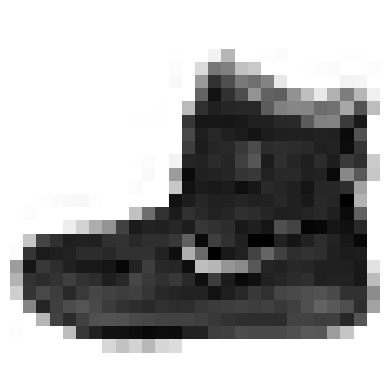

In [19]:
# Matplotlib을 사용하여 첫 번째 이미지를 시각화합니다
plt.imshow(X_train[0], cmap="binary")  # binary 색상 맵을 사용하여 흑백 이미지로 표시
plt.axis('off')  # 축 눈금과 레이블을 숨깁니다
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [20]:
y_train# 레이블 값을 확인합니다 (0부터 9까지의 정수)
y_train  # 각 이미지에 대한 클래스 ID가 담긴 배열

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Here are the corresponding class names:

In [21]:
# 클래스 ID에 대응하는 클래스 이름을 정의합니다
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


So the first image in the training set is a Ankle boot:

In [22]:
# 첫 번째 이미지의 클래스 이름을 확인합니다
class_names[y_train[0]]  # 'Ankle boot'

'Ankle boot'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [23]:
X_valid.shape

(5000, 28, 28)

In [24]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

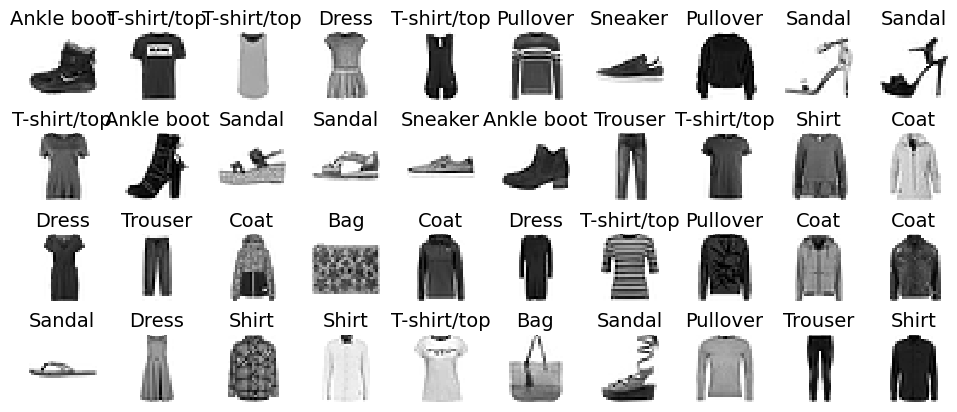

In [25]:
# extra code – this cell generates and saves Figure 10–10
# 데이터 인덱스에서 에러가 생겨서 인덱스 범위를 적절히 제한해서 해결하는 방법을 사용용
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        if index < len(X_train):  # 유효한 인덱스인지 확인
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[y_train[index]])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### ==P5. Using Keras to load the dataset (2)==
#### 아래 cell에 41번째 데이터의 그림과 label을 표시하는 코드를 작성하고 실행

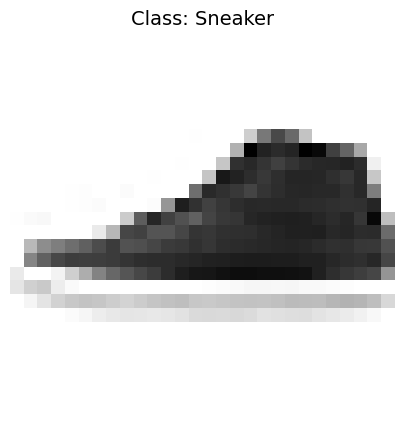

In [26]:
# Plot and label the 41st data
plt.figure(figsize=(5, 5))
plt.imshow(X_train[41], cmap="binary") #41번째
plt.axis('off')
plt.title(f"Class: {class_names[y_train[41]]}")
plt.show()

### Creating the model using the Sequential API

In [27]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28])) #input 뉴런 수
model.add(tf.keras.layers.Flatten()) #hidden layer의 수와 그 뉴런의 수수
model.add(tf.keras.layers.Dense(300, activation="relu")) #first hidden layer, 300 neurons
model.add(tf.keras.layers.Dense(100, activation="relu")) #second hidden layer, 100 neurons
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [28]:
# extra code – clear the session to reset the name counters
keras.backend.clear_session()
#np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


### ==P.6 Creating the model using the Sequential API(1)==
#### 위에서 정의한  'model'의 
#### 1. input neuron의 수: 784개 (28×28 픽셀 이미지를 1차원으로 펼친 형태)
#### 2. hidden layer의 수와 각 hidden layer의 neuron의 수:
1) 2개의 hidden layer
2) 첫 번째 hidden layer: 300개 neuron (ReLU 활성화 함수)
3) 두 번째 hidden layer: 100개 neuron (ReLU 활성화 함수)
#### 3. 출력층의 neuron의 수: 10개 (10개 클래스에 대한 softmax 활성화 함수)
#### 4. 총 parameter의 수: 266,610개
1) Flatten 층: 0개 매개변수
2) 첫 번째 Dense 층: 784×300 + 300 = 235,500개
3) 두 번째 Dense 층: 300×100 + 100 = 30,100개
4) 출력 Dense 층: 100×10 + 10 = 1,010개

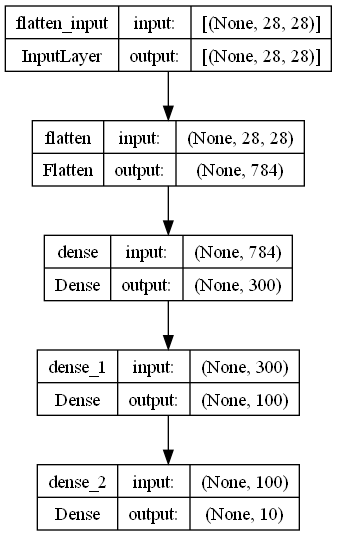

In [30]:
# extra code – another way to display the model's architecture
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [31]:
model.layers

In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer(hidden1.name) is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.00343052, -0.04669873,  0.07190955, ..., -0.00591172,
        -0.03201968, -0.01744922],
       [-0.02820578, -0.06510393, -0.00827076, ...,  0.00410318,
        -0.06866336,  0.07374378],
       [-0.0024545 ,  0.04647633, -0.01548439, ...,  0.06306386,
        -0.04506939, -0.07315479],
       ...,
       [ 0.00456608, -0.03629314,  0.01749453, ...,  0.00080615,
        -0.01069765, -0.06978765],
       [-0.07021043,  0.00342049,  0.0472281 , ...,  0.05510804,
         0.00173245, -0.0729407 ],
       [-0.02826744,  0.01277614, -0.03043617, ...,  0.03791513,
        -0.02329628, -0.03473771]], dtype=float32)

In [35]:
weights.shape

(784, 300)

In [36]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
biases.shape

(300,)

### ==P.7 Creating the model using the Sequential API(2)==
####  마지막 input neuron과 첫번째 hidden layer의 마지막 neuron 사이의 weigh와 bias의 초기값(소수점 4자리이후 버림 )
#### Answer: weigh : -0.0347 , bias : 0.0000
-

In [38]:
# 마지막 input neuron과 첫번째 hidden layer의 마지막 neuron 사이의 weight와 bias 확인
print(f"Weight: {weights[783, 299]:.4f}")
print(f"Bias: {biases[299]:.4f}")

Weight: -0.0347
Bias: 0.0000
